In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import time
%matplotlib inline

In [2]:
transform = transforms.ToTensor() # Transforms to float tensor [0,1]

MNIST Dataset 

In [3]:
train_data = datasets.MNIST(root='./Data/', train=True, download=True, transform=transform)

In [4]:
test_data = datasets.MNIST(root='./Data/', train=False, download=True, transform=transform)

In [5]:
image, label = train_data[0]

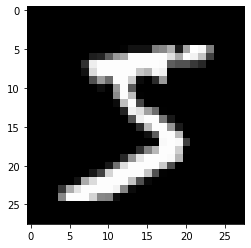

In [6]:
plt.imshow(image.reshape(28,28), cmap='gray')

In [7]:
torch.manual_seed(101)

In [8]:
train_loader = DataLoader(train_data, batch_size=100, shuffle=True)

In [9]:
test_loader = DataLoader(test_data, batch_size=500, shuffle=False)

In [10]:
from torchvision.utils import make_grid
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}' ))

In [11]:
for images, labels in train_loader: # Loading a batch
    break

In [12]:
labels.shape

torch.Size([100])

Labels:  [   4    6    2    3    4    0    9    5    0    1    6    9]


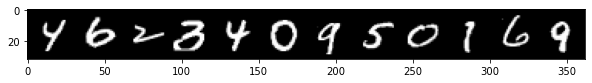

In [13]:
print('Labels: ', labels[:12].numpy())
im = make_grid(images[:12], nrow=12)
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(), (1,2,0)))

In [14]:
class MultilayerPerceptron(nn.Module):
    
    # Fully connected layers
    # Relu Feed Forward
    # Multi-class classification activation function (softmax)

    def __init__(self, in_sz=784,out_sz=10,layers=[120,84]):
        super().__init__()
        self.fc1 = nn.Linear(in_sz, layers[0])
        self.fc2 = nn.Linear(layers[0], layers[1])
        self.fc3 = nn.Linear(layers[1], out_sz)

    def forward(self, X):
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X,dim=1)

In [15]:
torch.manual_seed(101)
model = MultilayerPerceptron()

In [16]:
for param in model.parameters():
    print(param.numel())

94080
120
10080
84
840
10


In [17]:
criterion = nn.CrossEntropyLoss() # Loss minimization function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # Step sizes

In [18]:
images.shape

torch.Size([100, 1, 28, 28])

In [19]:
images.view(100, -1).shape # 100, 28x28x1 

torch.Size([100, 784])

In [20]:
start_time = time.time()

epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0

    for b, (X_train, y_train) in enumerate(train_loader):
        b += 1

        y_pred = model(X_train.view(100,-1))
        loss = criterion(y_pred, y_train)

        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if b%200 == 0:
            accuracy = trn_corr.item()*100/(100*b)
            print(f'Epoch {i} batch {b} loss {loss.item} accuracy: {accuracy}')

    train_losses.append(loss)
    train_correct.append(trn_corr)

    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            y_val = model(X_test.view(500, -1))
            predicted = torch.max(y_val, 1)[1]
            tst_corr += (predicted==y_test).sum()
    
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

total_time = time.time() - start_time
print(f'Duration: {total_time/60} mins')

Epoch 0 batch 200 loss <built-in method item of Tensor object at 0x000001AE6CE84540> accuracy: 83.585
Epoch 0 batch 400 loss <built-in method item of Tensor object at 0x000001AE6CE23F40> accuracy: 87.945
Epoch 0 batch 600 loss <built-in method item of Tensor object at 0x000001AE6CE84440> accuracy: 89.78833333333333
Epoch 1 batch 200 loss <built-in method item of Tensor object at 0x000001AE6CE23E00> accuracy: 94.96
Epoch 1 batch 400 loss <built-in method item of Tensor object at 0x000001AE6CE84D40> accuracy: 95.1775
Epoch 1 batch 600 loss <built-in method item of Tensor object at 0x000001AE6CE23E40> accuracy: 95.41
Epoch 2 batch 200 loss <built-in method item of Tensor object at 0x000001AE6CE72140> accuracy: 96.62
Epoch 2 batch 400 loss <built-in method item of Tensor object at 0x000001AE6CE84F00> accuracy: 96.6775
Epoch 2 batch 600 loss <built-in method item of Tensor object at 0x000001AE6CE72440> accuracy: 96.74166666666666
Epoch 3 batch 200 loss <built-in method item of Tensor object

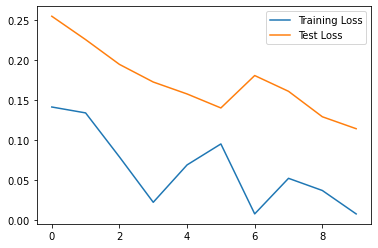

In [21]:
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()

Performance degradation on unseen data.

Over-fitting around 10th epoch.

In [43]:
train_acc = [t/600 for t in train_correct]
test_acc = [t/100 for t in test_correct]

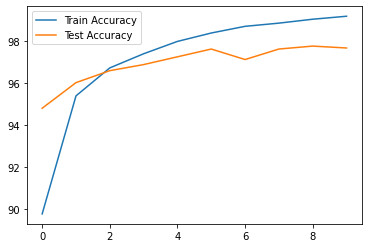

In [45]:
plt.plot(train_acc, label='Train Accuracy')
plt.plot(test_acc, label='Test Accuracy')
plt.legend()

In [47]:
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

In [48]:
with torch.no_grad():
    correct = 0

    for X_test, y_test in test_load_all:
        y_val = model(X_test.view(len(X_test), -1))
        predicted = torch.max(y_val, 1)[1]
        correct += (predicted == y_test).sum()

In [53]:
100* correct.item()/len(test_data)

97.69

In [75]:
confusion_matrix(predicted.view(-1), y_test.view(-1))

array([[ 974,    0,    7,    0,    1,    2,    6,    0,   10,    0],
       [   0, 1126,    1,    0,    0,    0,    3,    8,    0,    2],
       [   1,    3, 1015,   11,    2,    0,    3,   18,   11,    0],
       [   0,    1,    2,  974,    0,   10,    1,    0,    5,    1],
       [   1,    0,    2,    0,  965,    2,    6,    3,    4,    9],
       [   0,    0,    0,    3,    0,  866,    3,    0,    2,    1],
       [   1,    2,    0,    0,    4,    4,  936,    0,    1,    0],
       [   1,    0,    1,    5,    0,    2,    0,  987,    4,    1],
       [   2,    3,    3,    3,    0,    1,    0,    2,  932,    1],
       [   0,    0,    1,   14,   10,    5,    0,   10,    5,  994]],
      dtype=int64)